# TODO:
### DQN on cartpole 
- [x] Read about DQN and plan classes
- [ ] Test for dtypes, shapes, correct gradient changes, everything is a tensor, tests for making sure no_grad is on in the right points
- [ ] Assert optimiser has zero grad just before it calculates the gradients
- [ ] Make sure every input to a network is a tensor, and every input to a gym env is of right type and shape

#### Questions/cheat sheet
- When do i stop the gradients? Only have gradients when computing the loss for an update. 
    - Compute gradients for calculating things which have used the weights which need updating. 
    - I don't want requires_grad for environment outputs, only weights/params in the learnable nets
- Do the dimensions of inputs to network have to include batch size, even if it is always 1?  I think so. Whenever an input goes into a network basically.
- How do i pass a gradient through a distribution
    - Using rdist
- Convert everything that needs to go into a network to a tensor, float, device, has to have 0th dim as batch size when input for a net
    - Dtype is float for everything since tensors are only used to go in the network. 
    - So the dtype only matters in the networks, and float is safe for passing through networks.
- Use `.gather()` for getting the Q values as it is differentiable 
- Do i need to do a deepcopy of all transitions when sampling from buffer? 
    - No because I convert them to a tensor anyway which produces a new memory and reference
- Only need to transfer to device when I when I create a new tensor or model that you want the parameters to be on cuda. 
    - So model has params (weights) so it is on cuda, most loss functions are not on cuda, any inputs and outputs to something on cuda are on cuda, so states etc, inputs etc have to be on cuda.

In [16]:
import gym
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from collections import deque
from gym.spaces.box import Box
from typing import List, Tuple
from deeprl.common.utils import get_gym_space_shape, net_gym_space_dims
from torch.distributions import Categorical
from deeprl.common.base import *

In [20]:
env = gym.make("CartPole-v1")

<OrderEnforcing<CartPoleEnv<CartPole-v1>>>

In [2]:
class Network(nn.Module):
    def __init__(self, design: List):
        '''
        Args:
            design List(Tuple): Each Tuple is of form (nn.Layer, {param_name: param_values})
        '''
        super().__init__()
        self.layers = []
        

        for i in range(len(design)):
            layer_type, params = design[i]
            self.layers.append(layer_type(**params))

        self.net = nn.Sequential(*self.layers)

    def forward(self, x):
        assert type(x) == torch.Tensor
        assert x.dim() > 1
        assert x.dtype in [float, torch.float64, torch.float32]
        
        out = self.net(x)
        return out


In [3]:
ENVNAME = 'CartPole-v1'
env = gym.make(ENVNAME)
# env2 = gym.make('BipedalWalker-v3')

In [4]:
net_gym_space_dims(env.observation_space)

4

In [5]:
des = [
    (nn.Linear, {"in_features":net_gym_space_dims(env.observation_space), "out_features":128}),
    (nn.ReLU, {}),
    (nn.Linear, {"in_features":128, "out_features": 64}),
    (nn.ReLU, {}),
    (nn.Linear, {"in_features":64, "out_features": net_gym_space_dims(env.action_space)})
]

In [6]:
Network(des)

Network(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [7]:
class CategoricalPolicy(Network):
    def __init__(self, arch):
        super().__init__(arch)

    def sample(self, state, action=None):
        params = self.forward(state)  # gives unnormalised logits
        assert type(params) == torch.Tensor
        assert torch.is_floating_point(params)

        prob_dist = Categorical(logits=params)  # use logits if unnormalised,

        if action is None:
            action = prob_dist.sample()

        log_prob = prob_dist.log_prob(action)
        entropy = prob_dist.entropy()

        return action, log_prob, entropy



In [8]:
state = env.reset()
state = torch.tensor([state], dtype=torch.float)
policy = CategoricalPolicy(des)
a, lp, ent = policy.sample(state)


C:\Users\akshil\AppData\Local\Temp\ipykernel_13920\801187613.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  state = torch.tensor([state], dtype=torch.float)


In [9]:
env.action_space.contains(a.cpu().detach().squeeze().numpy())

True

In [10]:
assert type(lp) == torch.Tensor
assert lp.dtype == torch.float
assert lp.requires_grad
assert lp.shape == (1,)


In [11]:
assert type(ent) == torch.Tensor
assert ent.dtype == torch.float
assert ent.requires_grad
assert ent.shape == (1,)


In [12]:
class A2C:
    def __init__(self, args):     
        self.device = args["device"]
        self.gamma = args["gamma"]
        self.env = args["env"]
        self.step_lim = args["step_lim"]

        # Critic
        self.critic = args["critic"].to(self.device)
        self.critic_lr = args["critic_lr"]
        self.critic_optimiser = args["critic_optimiser"](
            self.critic.parameters(), self.critic_lr
        )
        self.critic_criterion = args["critic_criterion"]

        # Policy
        self.policy = args["policy"].to(self.device)
        self.policy_lr = args["policy_lr"]
        self.policy_optimiser = args["policy_optimiser"](
            self.policy.parameters(), self.policy_lr
        )
        self.entropy_coef = args["entropy_coef"]
        # self.adv_n = 0.
        # self.adv_mean = 0.


    def train(self, num_episodes:int, render=False, verbose=True) -> np.array:
        """This is a wrapper method around the `run_episode` method. We use `train` mehod for running experiments. 

        Args:
            num_episodes (int): The number of episodes for which to run training.
            render (bool, optional): Flag used to render episodes to watch training. Defaults to False.
            verbose (bool, optional): Used to decide if we should . Defaults to True.

        Returns:
            numpy array: Array of shape (num_episodes,) which contains the episodic rewards returned by the `run_episode` method. 
        """

        total_rewards = np.zeros(num_episodes)
        for i in range(num_episodes):
            total_rewards[i] = self.run_episode(render=render) 

            if i%10==0 and verbose:
                print("Episode {}, Reward {}".format(i, total_rewards[i]))
        return total_rewards

    def run_episode(self, render=False):
        """Functionality for running an episode with updating.

        Args:
            render (bool, optional): Flag used to render episodes to watch training. Defaults to False. Defaults to False.

        Returns:
            _type_: _description_
        """
        state = self.env.reset()
        episodic_reward = 0.
        step_counter = 0
        while step_counter < self.step_lim:
            
            action, log_prob, entropy = self.choose_action(state)
            next_state, reward, done, _ = self.env.step(action)

            episodic_reward += reward 
            step_counter +=1
            
            if render: self.env.render()
            
            losses = self.update(state, reward, next_state, done, log_prob, entropy)
            
            if done: 
                # print(losses)
                break

            state = next_state

        return episodic_reward

    def update(self, state, reward, next_state, done:bool, log_prob, entropy):
        """One step update which:
        1) Converts the experience to tensors and puts on the correct device
        2) Calls `.compute_adv_and_td_target` method to compute the advantage and td_target (without gradients) 
        3) Calls the `update_policy` and `update_critic` methods using the advantage and td_target to update both policy and critic.

        Args:
            state (numpy array): State from which the agent starts the transition
            reward (float or int): One step reward for the transition
            next_state (numpy array): Next state after taking the action.
            done (bool): True iff the next_state was terminal. 
            log_prob (torch.FloatTensor): shape=(1,1)
            entropy (torch.FloatTensor): shape=(1,1)

        Returns:
            Tuple(float, float): (Policy Loss, Critic Loss) computed for the transition.
        """

        state = torch.tensor([state], dtype=torch.float, device=self.device)
        next_state = torch.tensor([next_state], dtype=torch.float, device=self.device)
        # done = torch.tensor(done, dtype=torch.int, device=self.device) # are these two lines needed since they don't go through a model.
        # reward = torch.tensor(reward, dtype=torch.float, device=self.device)

        # print(state, next_state, done, reward)

        # These are both targets so no need to track grads
        # with torch.no_grad():
        adv, td_target = self.compute_adv_and_td_target(state, reward, next_state, done)

        assert not adv.requires_grad
        assert not td_target.requires_grad

        policy_loss = self.update_policy(log_prob, entropy, adv)
        critic_loss = self.update_critic(td_target, state)

        return policy_loss, critic_loss

    def update_policy(self, log_prob, entropy, adv):
        
        assert not adv.requires_grad
        assert log_prob.requires_grad
        # print(log_prob)
        # print(adv)
        
        policy_loss = -(log_prob * adv) #- (entropy * self.entropy_coef)
        # print(policy_loss, policy_loss.shape)
        policy_loss = policy_loss.squeeze()

        self.policy_optimiser.zero_grad()
        policy_loss.backward()
        # nn.utils.clip_grad_norm_(self.policy.parameters(), 0.2)
        self.policy_optimiser.step()

        return policy_loss.item()

    def update_critic(self, td_target, state):
        # Compute the current state value with grads
        # Compute the 
        
        assert not td_target.requires_grad

        current_state_val = self.critic(state)
        assert td_target.shape == current_state_val.shape
        assert current_state_val.requires_grad
        
        critic_loss = self.critic_criterion(current_state_val, td_target)
        assert critic_loss.shape == ()
        
        self.critic_optimiser.zero_grad()
        critic_loss.backward()
        # nn.utils.clip_grad_norm_(self.critic.parameters(), 0.2)
        self.critic_optimiser.step()

        return critic_loss.item()

    @torch.no_grad()
    def compute_adv_and_td_target(self, state, reward, next_state, done):
        

        td_target = reward + self.gamma * self.critic(next_state) * (1-done)
        adv = td_target - self.critic(state)
        
        assert not td_target.requires_grad
        assert not adv.requires_grad
        assert adv.shape == (1,1)
        assert td_target.shape == (1,1)
        

        
        return adv, td_target

    
    def choose_action(self, state):
        # Convert state to torch tensor
        # Pass state to policy net
        # Convert action to numpy 
        state = torch.tensor([state], dtype=torch.float, device=self.device)
        action, log_prob, entropy = self.policy.sample(state)

        action = action.cpu().detach().numpy().squeeze()
        
        assert self.env.action_space.contains(action)

        return action, log_prob, entropy

In [13]:
env = gym.make("CartPole-v1")
policy_layers = [
    (nn.Linear,
        {"in_features": net_gym_space_dims(env.observation_space),
        "out_features": 32}),
    (nn.Tanh, {}),
    (nn.Linear,
        {"in_features": 32,
        "out_features": 32}),
    (nn.Tanh, {}),
    (nn.Linear,{"in_features": 32, "out_features": net_gym_space_dims(env.action_space)}),
]

critic_layers = [
    (nn.Linear, {"in_features": net_gym_space_dims(env.observation_space), "out_features": 32}),
    (nn.ReLU, {}),
    (nn.Linear,
        {"in_features": 32,
        "out_features": 32}),
    (nn.ReLU, {}),
    (nn.Linear, {"in_features": 32, "out_features": 1}),
]

a2c_args = {
    "gamma": 0.99,
    "env": env,
    "step_lim": 200,
    "policy": CategoricalPolicy(policy_layers),
    "policy_optimiser": optim.Adam,
    "policy_lr": 0.001,
    "critic": Network(critic_layers),
    "critic_lr": 0.001,
    "critic_optimiser": optim.Adam,
    "critic_criterion": nn.MSELoss(),
    "device": "cpu",
    "entropy_coef": 0.01,
}


In [14]:
agent = A2C(a2c_args)
s = env.reset()
for _ in range(200):
    a, lp, ent = agent.choose_action(s)
    assert env.action_space.contains(a)
    assert lp.requires_grad
    assert ent.requires_grad
    s_, r, d, _ = env.step(a)
    if d:
        s = env.reset()
    else:
        s = s_

Running training for agent number 0
Episode 0, Reward 20.0
Episode 10, Reward 92.0
Episode 20, Reward 50.0
Episode 30, Reward 17.0
Episode 40, Reward 119.0
Episode 50, Reward 121.0
Episode 60, Reward 200.0
Episode 70, Reward 200.0
Episode 80, Reward 30.0
Episode 90, Reward 30.0
Episode 100, Reward 26.0
Episode 110, Reward 23.0
Episode 120, Reward 9.0
Episode 130, Reward 9.0
Episode 140, Reward 8.0
Episode 150, Reward 9.0
Episode 160, Reward 10.0
Episode 170, Reward 8.0
Episode 180, Reward 9.0
Episode 190, Reward 10.0
Running training for agent number 1
Episode 0, Reward 10.0
Episode 10, Reward 10.0
Episode 20, Reward 10.0
Episode 30, Reward 8.0
Episode 40, Reward 10.0
Episode 50, Reward 11.0
Episode 60, Reward 9.0
Episode 70, Reward 9.0
Episode 80, Reward 9.0
Episode 90, Reward 8.0
Episode 100, Reward 10.0
Episode 110, Reward 9.0
Episode 120, Reward 10.0
Episode 130, Reward 9.0
Episode 140, Reward 11.0
Episode 150, Reward 9.0
Episode 160, Reward 10.0
Episode 170, Reward 9.0
Episode 180

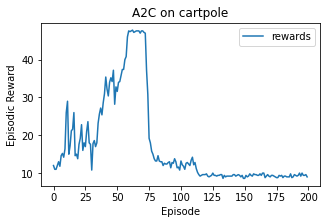

In [21]:
num_agents = 5
num_epi = 200
r = []

for i in range(num_agents):
    print("Running training for agent number {}".format(i))
    agent = A2C(a2c_args)
        
    # random.seed(i)
    # np.random.seed(i)
    # torch.manual_seed(i)
    # env.seed(i)

    r.append(agent.train(num_epi))

out = np.array(r).mean(0)

plt.figure(figsize=(5, 3))
plt.title('A2C on cartpole')
plt.xlabel('Episode')
plt.ylabel('Episodic Reward')
plt.plot(out, label='rewards')
plt.legend()

# plt.savefig('./data/a2c_cartpole.PNG')
plt.show()